In [ ]:
# default_exp poisson

# poisson

Tools for parameterizing log likelihood curves.

Author(s): Eric Wallace, Matthew Kerr, Toby Burnett

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
from scipy import optimize

class Poisson(object):
    r"""This is a functor class that manages a three-parameter Poisson-like function used to approximate the
    likelihood for a flux measurement, obtained by counting events. Since the actual likelihood is often 
    very compute intensive, this function can be very useful for subsequent analysis. The class `PoissonFitter` 
    is used to sample a function and produce a `Poisson` object.
    
    The array of parameters are, in order:

    $s_p$ : flux at the peak, if positive; if negative, there will be only a limit

    $e$  : scale factor to convert flux to equivalent counts. must be >0

    $b$  : background flux: must be >=0 (the case $e=b=0$ is the standard Poisson)
        
    This parameterization is equivalent to that described in William
    Tompkins' thesis (arxiv: astro-ph/0202141) and Nolan, et al., 2003, ApJ 597:615:627. 
        
    The function of flux  $s>=0$,  returned by the function, defining  $w=\log\mathcal{L}$ is
    
    $$w(s| s_p,e,b) = e\ (s_p+b) \ \log( e\ (s+b) ) - e\ s + \mathrm{const}$$
    
    
    the const is such that $w=0$ at the peak.
    
    A slightly more elegant expression, used in the `cdf` function, is to define
       $\beta = e b_s$, $\mu = e s_p + \beta$, and $x = e s$, so $x$ is in count units, is      
    
        
    $$ w'(x) =  \mu \ \log( x + \beta) - x + \mathrm{const} $$
    
    
    where the peak is at $x=x_p=\max(0, \mu-\beta)$, and the constant is defined so that $w'(x_p)=0$. 
    
    
    """
    def __init__(self, p:'array of parameters'):
        """p : array of parameters
        """
        self.p = p 
    
    def __call__(self, dom):
        """Return the value(s) of the fit function for the given domain."""
        sp,e,b = self.p
        b = abs(b) # this is a bit of a kluge to keep log argument positive
        if b==0: b = 1e-20 #another kludge
        e = abs(e) #and another
        r = e*(dom+b)
        r_peak = e*(sp+b)
        if sp > 0:
            const = r_peak*np.log(r_peak) - r_peak
        else:
            #sp=0
            #const = r_peak*np.log(r_peak) - r_peak
            t = e*b
            const = r_peak*np.log(t) - t
        f = r_peak*np.log(r) - r
        return f - const

    def __str__(self):

        e, beta, mu = self.altpars()
        return f'Poisson: mu,beta= {mu:.1f}, {beta:.1f}' 
    
    def __repr__(self):
        if self.flux==0:
            return 'flux is zero for source'
        t = np.array(self.errors)/self.flux-1
        relerr = np.abs(np.array(self.errors)/self.flux-1)
        return f'{self.__module__}.{self.__class__.__name__}: {self.flux:.3f}[1+{relerr[0]:.3f}-{relerr[1]:.3f}]'

    @property
    def flux(self):
        return max(self.p[0], 0)
    
    @property
    def errors(self):
        return self.find_delta()
        
    @property
    def ts(self):
        return 0 if self.flux<=0 else (self(self.flux)-self(0))*2.0
    
        
    def altpars(self):
        """ return alternate parameters: e, beta, mu """
        e = abs(self.p[1])
        beta = e * abs(self.p[2])
        mu =   e * self.p[0] + beta
        return e,beta,mu
    
    def find_delta(self,delta_logl=.5):
        """Find points where the function decreases by delta from the max"""
        smax = max(0,self.p[0])
        ll_max = self(smax)
        ll_zero = self(0)
        func = lambda s: ll_max-self(s)-delta_logl
        if ll_max-ll_zero<delta_logl:
            s_low = 0
        else:
            s_low = optimize.brentq(func,0,smax,xtol=1e-17)
        if smax>0:
            s_high = smax*10
        else:
            s_high = 1e-15
        while func(s_high)<0: s_high*=2
        #s_high = optimize.bisect(func,smax,s_high,xtol=.01*smax)
        s_high = optimize.brentq(func,smax,s_high,xtol=1e-17)
        if not np.all(np.isreal([s_low,s_high])):
            print('Could not find two roots!')
            return None
        return (s_low,s_high)

    def cdf(self, flux ):
        """ cumulative Bayesian pdf, from flux=0."""
#         It uses an incomplete gamma function for integrals. (Note that the scipy function
#         is a regularized incomplete gamma function)

        e, beta, mu = self.altpars()
        offset = special.gammainc(mu+1, beta) # Bayes offset if beta>0
        return (special.gammainc(mu+1, beta+flux*e)-offset)/(1-offset)

    def cdfc(self,flux):
        """ complementary cumulative cdf: 1-cdf(flux)"""
        e, beta, mu = self.altpars()
        return special.gammaincc(mu+1, beta+flux*e)/special.gammaincc(mu+1, beta)

    def cdfinv(self, pval):
        """ return the inverse of the cdf 
         pval : float
        """
        e,beta,mu = self.altpars()
        gbar = lambda x : special.gammainc(mu+1, beta+x)
        chatinv = lambda pv : special.gammaincinv(mu+1, pv+gbar(0)*(1-pv))-beta
        return  chatinv(pval)/e
        
    def cdfcinv(self, pvalc): 
        """ return the inverse of cdfc = 1-cdf
        useful for limits with very low probablity
        pvalc : float
            1-pval: zero corresponds to infinite flux
        """
        e,beta,mu = self.altpars()
        if e==0: return np.nan
        gcbar = lambda x : special.gammaincc(mu+1, beta+x)
        #cchat = lambda x : gcbar(x)/gcbar(0)
        cchatinv = lambda pv : special.gammainccinv( mu+1, pv*gcbar(0) )-beta
        return cchatinv(pvalc)/e

    def percentile(self, limit=0.95):
        """Left for compatibility: use cdfinv or cdfcinv
        """
        if limit>=0.95: return self.cdfcinv(1-limit)
        return self.cdfinv(limit)
        
    def pts(self):
        return 0 if self.flux<=0 else (self(self.flux)-self(0))*2.0
        
    def zero_fraction(self):
        """ Return an estimate of the fraction of the probability that corresponds
        to negative flux. Assume only have to calculate if TS>0 or TS<16
        """
        if self.ts==0: return 1.0
        if self.ts>16: return 0.0
        #this assumes that self.cdfc(0) is 1.0, and that cdfc(-b) is the full integral
        return 1-1./self.cdfc(-self.p[2])

<h4 id="Poisson.__call__" class="doc_header"><code>Poisson.__call__</code><a href="__main__.py#L45" class="source_link" style="float:right">[source]</a></h4>

> <code>Poisson.__call__</code>(**`dom`**)

Return the value(s) of the fit function for the given domain.

       
Here we generate and plot several instances, all with the $e$ parameter set to one, so the flux is in counts.

The peak ($s_p$) and  background ($b$) parameters are chosen from the following list:

<p style="margin-left: 5%"><samp>[(10, 5), (10, 0), (-5, 5), (-5, 1)]</samp></p>

The first two, with the peak at 10, show the effect of background. The last two show an example with a
peak less than zero, so that the Bayesian likelihood peaks at zero, and the effect of background on it.


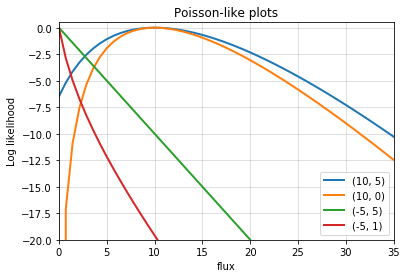

In [ ]:
show_doc(Poisson.__call__)
from jupydoc import Publisher
import numpy as np

class Demo(Publisher):
    def __call__(self, xlim=(0,35), ylim=(-20,0.5)):
        """
               
        Here we generate and plot several instances, all with the $e$ parameter set to one, so the flux is in counts.
        
        The peak ($s_p$) and  background ($b$) parameters are chosen from the following list:
        
        {pars}
        
        The first two, with the peak at 10, show the effect of background. The last two show an example with a
        peak less than zero, so that the Bayesian likelihood peaks at zero, and the effect of background on it.
        """
                
        pars = [(10,5), (10, 0), (-5, 5), (-5,1)]
        
        x = np.linspace(*xlim)
        ax = plt.gca()
        for p in pars:
            fun = Poisson([p[0], 1, p[1]])
            ax.plot(x, fun(x), label=str(p), lw=2) 
        ax.grid(alpha=0.5)
        ax.legend()
        ax.set(xlabel='flux', ylabel='Log likelihood', xlim=xlim, ylim=ylim, title='Poisson-like plots');
        ax.figure.set_facecolor('white')
        #---------------
        self.publishme()
Demo()()

In [ ]:
show_doc(Poisson.cdf)
show_doc(Poisson.cdfinv)
show_doc(Poisson.cdfc)
show_doc(Poisson.cdfcinv)

<h4 id="Poisson.cdf" class="doc_header"><code>Poisson.cdf</code><a href="__main__.py#L117" class="source_link" style="float:right">[source]</a></h4>

> <code>Poisson.cdf</code>(**`flux`**)

cumulative Bayesian pdf, from flux=0.

<h4 id="Poisson.cdfinv" class="doc_header"><code>Poisson.cdfinv</code><a href="__main__.py#L131" class="source_link" style="float:right">[source]</a></h4>

> <code>Poisson.cdfinv</code>(**`pval`**)

return the inverse of the cdf 
pval : float

<h4 id="Poisson.cdfc" class="doc_header"><code>Poisson.cdfc</code><a href="__main__.py#L126" class="source_link" style="float:right">[source]</a></h4>

> <code>Poisson.cdfc</code>(**`flux`**)

complementary cumulative cdf: 1-cdf(flux)

<h4 id="Poisson.cdfcinv" class="doc_header"><code>Poisson.cdfcinv</code><a href="__main__.py#L140" class="source_link" style="float:right">[source]</a></h4>

> <code>Poisson.cdfcinv</code>(**`pvalc`**)

return the inverse of cdfc = 1-cdf
useful for limits with very low probablity
pvalc : float
    1-pval: zero corresponds to infinite flux

In [ ]:
#export
import numpy as np
from scipy import optimize, special

class PoissonFitter(object):
    """ Manage a fit from log likelihood function to the poisson-like `Poisson`.
    
    * func : function of one parameter
    
    * fmax : position of maximum value, or None
           if None, estimate using fmin
    
    * scale: float | None
        estimate for scale to use; if None, estimate from derivative 
    
    * tol : float
        absolute tolerance in probability amplitude for fit, within default domain out to delta L of 4
    
    * delta : float
        value to calculate numerical derivative at zero flux
    
    """
    def __init__(self, func:'function of one parameter to fit',
                 fmax:'position of maximum, if known'=None, 
                 scale=None,  
                 tol=0.20, 
                 delta=1e-4, 
                 dd=-0.1, 
                 test_mode=False):
        """

        """
        self.func = func
        #first check derivative at zero flux - delta is sensitive
        self.f0 = func(0)
        s = self.wprime = (func(delta)-self.f0)/delta
        if scale is None: scale= 5/s if s>0 else 1.0
        self.smax = fmax or self.find_max(scale) if s>=0 else 0.

        self.ts = 2.*(func(self.smax) - self.f0)
        
        if test_mode:
            return
        # determine values of the function corresponding to delta L of 0.5, 1, 2, 4
        # depending on how peaked the function is, this will be from 5 to 8 
        # The Poisson will be fit to this set of values
        dlist = np.array([0.5, 1.0, 2.0, 4.0])
        if s < dd:
            # large negative derivative: this will be just an exponential
            if s < -100: s=-100. #cut off for now
            self.dom = - dlist/s
            self._poiss= Poisson([-1, -s, 1])
            self.maxdev=0
            return #no test in this case
        else:
            dom = set()
            for delta in dlist:
                a,b = self.find_delta(delta, scale, xtol=tol*1e-2)
                dom.add(a); dom.add(b)
            self.dom = np.array(sorted(list(dom)))
            self.fit()
        self.maxdev=self.check(tol)[0]
        
    def __repr__(self):
        return '%s.%s : wprime=%.3e maxdev=%.2f, %s' % (self.__module__,self.__class__.__name__,
            self.wprime, self.maxdev,  str(self._poiss))
    
    @property
    def poiss(self):
        return self._poiss
        
    def __call__(self, x):
        if hasattr(x, '__iter__'):
            ret =list(map(self.func, x))
            return ret[0] if len(ret)==1 else ret
        return self.func(x)

    def find_max(self, scale):
        """Return the flux value that maximizes the likelihood.
        """
        # if self.func(0) > self.func(scale/10.) and self.wprime<0:
        #     return 0
        r= optimize.fmin(lambda s: -self.func(s), scale, ftol=0.01, xtol=0.01, 
                disp=False, full_output=True, retall=True)
        t = r[0][0]
        #if t==scale:
        #    raise Exception('Failure to find max value: %s' % list(r))
        return t if t>0 else 0
    
    def find_delta(self, delta_logl=.5, scale=1.0, xtol=1e-5):
        """Find positive points where the function decreases by delta from the max
        """
        ll_max = self(self.smax)
        ll_zero = self(0)
        func = lambda s: ll_max-self(s)-delta_logl
        if ll_max-ll_zero<delta_logl:
            s_low = 0
        else:
            s_low = optimize.brentq(func,0, self.smax, xtol=xtol)
        if self.smax>0:
            s_high = self.smax*10
        else:
            s_high = scale
        while func(s_high)<0 and s_high<1e6: 
            s_high*=2
        s_high = optimize.brentq(func,self.smax,s_high, xtol=xtol)
        if not np.all(np.isreal([s_low,s_high])):
            msg = '%s.find_delta Failed to find two roots!' % self.__class__.__name__
            print(msg)
            raise Exception( msg)
        if s_high==s_low:
            msg= '%s.find_delta Failed to find high root with delta=%.1f: %s' % (self.__class__.__name__,delta_logl,s_high)
            print(msg)
            print('wprime: %.3e' % self.wprime)
            raise Exception(msg)
        return (s_low,s_high)

    def fit(self, mu=30, beta=5):
        """Do the fit, return parameters for a Poisson constructor
        mu, beta: initial parameters for the fit if the peak is positive
        """
        smax = self.smax
        if smax>0:
            # function to fit has positive peak. Fit the drived parameters mu, beta
            cod = self(self.dom)-self.func(smax)
            #print 'smax=%.2f, w(smax)=%s, w(%s)=%s' % (smax,self.func(smax), self.dom, cod)
            def fitfunc(p):
                mu,beta=p
                e=(mu-beta)/smax; b = beta/e
                self._poiss = Poisson([smax, e,b])
                r = self._poiss(self.dom)-cod
                #print'f(%.3f,%.3f): %s' % (mu,beta,r)
                return r
            mu,beta =  optimize.leastsq(fitfunc,[mu,beta], ftol=1e-6,xtol=1e-6, maxfev=10000)[0]
            e = (mu-beta)/smax; b = beta/e
            return [smax, e, b]
        else:
            # maximum is at zero, so only limit.
            x=self.dom; y=self(x)
            # exposure factor estimated from asymptotic behavior
            big= x[-1]*1e3; e = -self(big)/big; 
            # preliminary fit to the quadratic coeficients and estimate parameters from the linear and 2nd order
            pf = np.polyfit(x,y, 2)
            b,a = pf[:2] 
            beta = -e*(e+a)/(2.*b)
            mu = beta*(1+a/e)
            smax= (mu-beta)/e; b= beta/e 
            # now fit the Poisson with e fixed to the asym. estimate.
            cod = self(self.dom)-self(0)
            pinit = [smax,  b]
            def fitfunc(p):
                self._poiss = Poisson([p[0], e, p[1]])
                return self._poiss(x) -cod
            t =  optimize.leastsq(fitfunc,  pinit,  xtol=1e-6,ftol=1e-6, maxfev=10000)[0]
            return self._poiss.p

    def check(self, tol=0.05):
        offset = self(self.smax)
        dom =self.dom[1:] # ignore first one
        deltas = np.array([np.exp(self.func(x)-offset)-np.exp(self._poiss(x)) for x in dom])
        t = np.abs(deltas).max()
        if t>tol: 
            raise Exception(f'PoissonFitter: max dev= {t:.3f} > tol= {tol}. (wprime={self.wprime:.2f})' )
        return t, deltas
    
    def plot(self, ax=None, xticks=True ):
        """Return a figure showing the fit"""
        import matplotlib.pyplot as plt
        xp = self.dom
        x = np.linspace(0, xp[-1]*1.05, 25)
        if ax is None:
            fig, ax = plt.subplots(figsize=(3,3))
        else: fig = ax.figure
        pfmax = self(self.smax)
        ax.plot(x, np.exp(self(x)-pfmax), '-', label='Input function')
        ax.plot(xp, np.exp(self._poiss(xp)), 'o', label='Poisson approx.')
        ax.plot(x, np.exp(self._poiss(x)), ':')
        ax.legend(loc='upper right', prop=dict(size=8) )
        ax.set(xlim=(0,None), ylim=(0,1.05))
        if xticks:
            ax.set_xticks([0, xp[-1]])
        ax.grid(alpha=0.4)
        fig.set_facecolor('white')
        return fig

    def normalization_summary(self, nominal=None):
        """return a dict with useful stuff for normalization check
            nominal: None or float
                if specified, calculate delta_ts and pull
        """
        poiss = self.poiss
        lower, upper = poiss.errors
        maxl = poiss.flux
        err = self.maxdev
        if nominal is not None:
            mf =self(nominal)
            delta_ts = 2.*(self(maxl) - mf )
        if lower>0:
            pull = np.sign(maxl-mf) * np.sqrt(max(0, delta_ts))\
            if nominal is not None else None
            summary  = dict(
                maxl=maxl,
                lower=lower, upper=upper,
                ts=self.ts, # poiss.ts,
                err=err,
                )
        else:
            # just an upper limit
            pull = -np.sqrt(max(0, delta_ts)) if nominal is not None else None
            summary= dict(maxl=0,lower=0, upper=poiss.cdfinv(0.05), ts=0, 
                 err=err,
                )
        if nominal is not None:
            summary.update(delta_ts=delta_ts, pull=pull) 
        return summary     

In [ ]:
class Demo(Publisher):
    def __call__(self):
        """
        Test by fitting the same set of parameters;
        
        As with the `Poisson` test/demo, we use the following ($s_p, b$) pairs.
        
        {pars}
        
        The output:
        {printout}
        
        And plots showing the input function, 
        and the points that were used for the evaluation. 
        {fig}
        
        Note: the above figure, number {fig.number}, was put into the `images` folder, but needs to 
        have a unique file name.
        """
        pars = [(10,5), (10, 0), (-5, 5), (-5,1)]
        
        fig, axx = plt.subplots(1,4, figsize=(12,3), sharey=True)        
        with self.capture_print() as printout:
            for p,ax in zip(pars, axx.flatten() ):
                pf = PoissonFitter( Poisson([p[0], 1.0, p[-1]]) )
                print( f'error: {pf.check()[0]:.1e}, fit: {np.array(pf.fit()).round(3)}')
                pf.plot(ax=ax);
        fig.caption=None    
        self.publishme()
Demo()()

Test by fitting the same set of parameters;

As with the `Poisson` test/demo, we use the following ($s_p, b$) pairs.

<p style="margin-left: 5%"><samp>[(10, 5), (10, 0), (-5, 5), (-5, 1)]</samp></p>

The output:
<p style="margin-left: 5%"><pre>error: 2.3e-05, fit: [10.     1.     5.001]<br>error: 5.5e-04, fit: [ 9.997  1.    -0.   ]<br>error: 8.6e-13, fit: [-1.317  1.     1.317]<br>error: 3.9e-02, fit: [-4.771  1.033  0.986]<br></pre></p>

And plots showing the input function, 
and the points that were used for the evaluation. 
<div class="jupydoc_fig"><a href="images/fig_01.png"<figure>   <img src="images/fig_01.png" alt="Figure 1 at images/fig_01.png" > </figure></a></div>


Note: the above figure, number 1, was put into the `images` folder, but needs to 
have a unique file name.


In [ ]:
#hide
class NewFitter(object):
    """ Determine Poisson parameters for a likelihood function with positive value
    for maximum
    Designed for Kerr weighted likelihood, where maximum and sigma are easy to get.
    """
    def __init__(self, fun, x0, sig, guess=None):
        """ fun : function of a variable
            x0  : maximum
            sig : sigma at peak
        """
        self.fun = fun #loglike = loglike

        self.f, self.sf =  x0, sig 
        self.guess = guess or [(1/sig)**2,0.3] 
        self.set_dom()
        
    def set_dom(self, default=[-2,-1,1,2]):
        dom = self.f + self.sf*np.array(default)
        self.dom = np.array(list(filter(lambda x: x>0, dom)) )
        self.u = np.array(list(map(self.fun, self.dom))) - self.fun(self.f)
        
    def __call__(self,p):
        """Evaluate sum of squares
            p : parameters [e,b] 
        """
        pois = Poisson([self.f, *p])
        t = np.array(list(map(pois, self.dom)))
        return np.sum((t-self.u)**2)
    
    def fit(self, **kwargs):
        fitkw = dict(tol=1e-5)
        fitkw.update(kwargs)
        self.fit_info = t= optimize.minimize(self, self.guess, **fitkw )
        self.poiss = Poisson([self.f,*(t.x)])
        if t.status:
            raise Exception(f'Failed fit, {t.message}')

        return self.poiss
    
    def plot(self, ax=None, **kwargs):
        import matplotlib.pylab as plt 
        fig, ax = plt.subplots() if ax is None else (ax.figure, ax)
        f, sf = self.f, self.sf
        
        dom = np.linspace(max(0, f-4*sf), f+4*sf, 25)
        yp = np.array(list(map(self.poiss, dom)))
        yw = np.array(list(map(self.fun, dom)))-self.fun(f)
        ax.plot(dom, yw, '+', label='input funct.')
        ax.plot(dom, yp, '-', label='poisson approx')
        ax.axhline(0, color='grey', ls=':');
        for x in [f-sf, f, f+sf]:
            ax.axvline(x, color='orange', ls='--')
        ax.legend()
        ax.axhline(0, color='grey', ls='--')
        ax.set(ylim=(-9, 0.5,), ylabel='likelihood')